# Radial profiles, combining, reprojections, and smoothing

---


## Topics

 - refresher on concepts and terms from yesterday
   (you all remember what chips ACIS has, don't you?)

 - a reminder to review the helpful
   [What I Wish I Knew when Starting X-ray Astronomy](https://cxc.harvard.edu/cdo/xray_primer.pdf)
   primer

 - a (brief) overview on finding and preparing (public) Chandra observations
   for further analysis
   
   - I do **not** talk about background flares, which I really should (but Nick has already talked about this)
   
 - using `dmextract` to create a radial profile (it can also slice - extract spectra -
   and dice - create light curves)
   
 - use Sherpa to fit the profile (Aneta will talk more about Sherpa in 45 minutes)
 
   - what features are real, what are instrumental, and what is bad modelling?
   
 - if we have more data, we want to combine it to improve our signal-to-noise,
   but what does that really mean, and why should I care about reprojections,
   chip boundaries, and instrumental differences?
   
Unfortunately this is **waaaaay** to much for a Friday morning, so the idea is to introduce the ideas and point you to the documentation and threads for more details.
 
---


# The talk

Can we go from

![image](images/eta_carina_raw.png)

to

![image](images/eta_carina_merged.png)

Unfortunately most datasets are just not as pretty as Eta Carina!

# Pop Quiz

- Can anyone spot the readout streak?

- Do we only ever want to combine observations like the Eta Carina dataset? What about the CDF-S datasets?

- As the observatory has aged, why do the observation times seem to get smaller?

- https://cxc.harvard.edu/ciao/guides/

- https://cxc.harvard.edu/ciao/threads/

---

Let's start by checking the CIAO version (the output of `ciaover` depends on whether CIAO was installed with
`ciao-install` or `conda`; in this case I used `conda`):

In [1]:
!ciaover -v

# packages in environment at /home/dburke/anaconda/envs/ciao413:
#
# Name                    Version                   Build  Channel
ciao                      4.13.0           py38h5ec60c1_0    https://cxc.cfa.harvard.edu/conda/ciao
ciao-contrib              4.13.0                     py_4    https://cxc.cfa.harvard.edu/conda/ciao
ds9                       8.2                           2    https://cxc.cfa.harvard.edu/conda/ciao
sherpa                    4.13.0           py38h5ec60c1_0    https://cxc.cfa.harvard.edu/conda/ciao

System information:
Linux dburke-Precision-5530 5.4.0-59-generic #65-Ubuntu SMP Thu Dec 10 12:01:51 UTC 2020 x86_64 x86_64 x86_64 GNU/Linux


For this talk I am using an IPython notebook, but running many commands via the shell (by starting a line with the ! character). To save time I will not run all steps in the talk.

I want data on the $z \sim 1$ galaxy cluster around the QSO 3C 186. Let's search the Chandra archive:

In [2]:
!find_chandra_obsid '3C 186'

# obsid  sepn   inst grat   time    obsdate        piname    target
3098      0.0 ACIS-S NONE   34.4 2002-05-16 Siemiginowska Q0740+380
9407      0.0 ACIS-S NONE   66.3 2007-12-03 Siemiginowska  "3C 186"
9408      0.0 ACIS-S NONE   39.6 2007-12-11 Siemiginowska  "3C 186"
9774      0.0 ACIS-S NONE   75.1 2007-12-06 Siemiginowska  "3C 186"
9775      0.0 ACIS-S NONE   15.9 2007-12-08 Siemiginowska  "3C 186"


The fact that the PI is the same person who is giving you the next talk is purely coincidental, as is our [2010 paper on this cluster](https://ui.adsabs.harvard.edu/abs/2010ApJ...722..102S/abstract) you can read ...


# Pop Quiz time

- What's an ObsId?

- What does ACIS-S mean?

- Why is the observation date important?

- Is the target field meaningfull?

---

So, there was a "short" observation in 2002 and then ~200 ks of data in 2007. Let's grab them all (it can take a bit of
time, so

    download_chandra_obsid 9774
    
can be used to access just a single ObsId). Apologies for the wall of text here!

In [3]:
!mkdir data

In [4]:
cd data

/home/dburke/talks/ciao_workshop_jan_21_aas237/notebooks/data


In [5]:
!find_chandra_obsid '3C 186' download=all


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  vv       pdf        73 Mb  ####################           43 s  1739.2 kb/s
  asol     fits        9 Mb  ####################            7 s  1453.1 kb/s
  mtl      fits        8 Mb  ####################            2 s  4194.7 kb/s
  evt1     fits        3 Mb  ####################          < 1 s  4289.2 kb/s
  stat     fits        1 Mb  ####################          < 1 s  1612.0 kb/s
  evt2     fits        1 Mb  ####################          < 1 s  2127.4 kb/s
  aqual    fits      570 Kb  ####################          < 1 s  1388.5 kb/s
  osol     fits      366 Kb  ####################          < 1 s  1219.3 kb/s
  osol     fits      361 Kb  ####################          < 1 s  1141.3 kb/s
  osol     fits      352 Kb  ####################          < 1 s  1054.3 kb/s
  osol     fits      351 Kb  ####################          < 1 

# Pop Quiz

- What are all these different "types"?

- What ones should I care about?

- What's the **first** file I should review?

--- 

This has created five directories, one for each ObsId:

In [6]:
!ls

3098  9407  9408  9774	9775


## Reprocess the data!

This can take some time... 

I am **NOT** going to take time to look at the background rate (to see if there have been any flares) which I **REALLY SHOULD** do.

# Pop Quiz

- Why do we reprocess?

- Why do I call `punlearn`?

In [7]:
!punlearn chandra_repro

In [8]:
!plist chandra_repro


Parameters for /home/dburke/cxcds_param4/chandra_repro.par

         indir = ./               Input directory
        outdir =                  Output directory (default = $indir/repro)
         (root = )                Root for output filenames
     (badpixel = yes)             Create a new bad pixel file?
(process_events = yes)             Create a new level=2 event file?
     (destreak = yes)             Destreak the ACIS-8 chip?
   (set_ardlib = yes)             Set ardlib.par with the bad pixel file?
 (check_vf_pha = no)              Clean ACIS background in VFAINT data?
      (pix_adj = default)         Pixel randomization: default|edser|none|randomize
(recreate_tg_mask = no)              Re-run tgdetect and tg_create_mask rather than use the Level 2 region extension?
  (asol_update = yes)             If necessary, apply boresight correction to aspect solution file?
      (cleanup = yes)             Cleanup intermediate files on exit
      (clobber = no)              Clobber exi

In [9]:
!chandra_repro indir=* outdir=


Running chandra_repro
version: 01 December 2020



Processing input directory '/home/dburke/talks/ciao_workshop_jan_21_aas237/notebooks/data/3098'

Applying boresight update to aspect solution file
Resetting afterglow status bits in evt1.fits file...

Running acis_build_badpix and acis_find_afterglow to create a new bad pixel file...

Running acis_process_events to reprocess the evt1.fits file...
Output from acis_process_events:
# acis_process_events (CIAO 4.13): WARNING: The ra_targ, dec_targ, or roll_nom specified by /home/dburke/talks/ciao_workshop_jan_21_aas237/notebooks/data/3098/repro/pcadf03098_repro_obs.par does not match the values in the event file- using the obs.par values.
Filtering the evt1.fits file by grade and status and time...
Applying the good time intervals from the flt1.fits file...
The new evt2.fits file is: /home/dburke/talks/ciao_workshop_jan_21_aas237/notebooks/data/3098/repro/acisf03098_repro_evt2.fits

Updating the event file header with chandra_repro HISTOR

**NOTE** New to CIAO 4.13 is the helpful `WARNING` message

    The ra_targ, dec_targ, or roll_nom specified by /blah/blah/blah_obs.par does not match the values in the event file- using the obs.par values.

This is thanks to a new correction to handle changes in our understanding of the alignment of the telescope and can (at least here), be ignored.

# Pop Quiz

Rember virtual filtering?

In [10]:
!dmstat 9774/repro/acisf09774_repro_evt2.fits"[ccd_id=3,sky=circle(4100,4100,30)][cols energy]"

# DMSTAT (CIAO 4.13): WARNING: no rows found in table 9774/repro/acisf09774_repro_evt2.fits[ccd_id=3,sky=circle(4100,4100,30)][cols energy]

energy[eV]
    min:	0 	      @:	0 
    max:	0 	      @:	0 
   mean:	0 
  sigma:	0 
    sum:	0 
   good:	0 
   null:	0 



Darn it - I meant `ccd_id=7`...

## What does the data look like?

We can use the `fluximage` script to create exposure-map corrected images (as with `chandra_repro` this packages up a numbre of different tasks that call CIAO commands):

In [11]:
!punlearn fluximage
!fluximage 9774/ 9774/fluxed/

Running fluximage
Version: 01 April 2020

Found 9774/repro/acisf09774_repro_evt2.fits
Using event file 9774/repro/acisf09774_repro_evt2.fits
Using CSC ACIS broad science energy band.
Aspect solution 9774/repro/pcadf09774_repro_asol1.fits found.
Bad-pixel file 9774/repro/acisf09774_repro_bpix1.fits found.
Mask file 9774/repro/acisf09774_000N002_msk1.fits found.

The output images will have 386 by 412 pixels, pixel size of 3.936 arcsec,
    and cover x=2056.5:5144.5:8,y=3176.5:6472.5:8.

Running tasks in parallel with 12 processors.
Creating aspect histograms for obsid 9774
Creating 5 instrument maps for obsid 9774
Creating 5 exposure maps for obsid 9774
Combining 5 exposure maps for obsid 9774
Thresholding data for obsid 9774
Exposure-correcting image for obsid 9774

The following files were created:

 The clipped counts image is:
     9774/fluxed/broad_thresh.img

 The clipped exposure map is:
     9774/fluxed/broad_thresh.expmap

 The exposure-corrected image is:
     9774/fluxed/broa

You can use `ds9` to view these, but it doesn't work well in a shared notebook, so let's display
it within the notebook using crated (to read the data) and matlotlib (to display the data):

In [12]:
import numpy as np
from matplotlib import pyplot as plt
import pycrates

%matplotlib inline

In [13]:
cr = pycrates.read_file('9774/fluxed/broad_thresh.img')
pixvals = cr.get_image().values

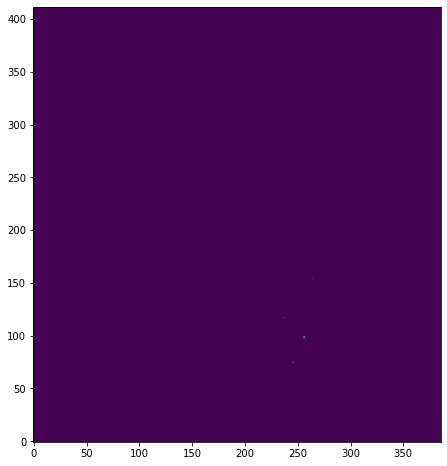

In [14]:
plt.figure(figsize=(8, 8))
plt.imshow(pixvals, origin='lower')

Well, that doesn't lool very pretty. How about using a log scale?

<ipython-input-15-67ead6e88e68>:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(pixvals), origin='lower')


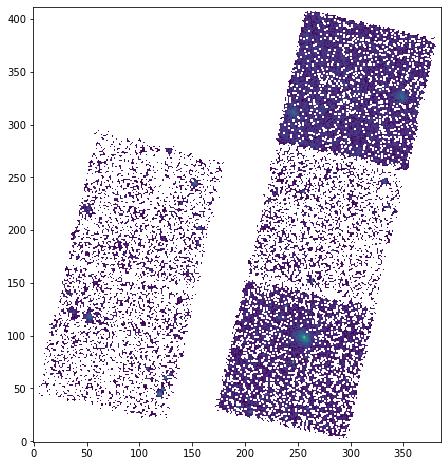

In [15]:
plt.figure(figsize=(8, 8))
plt.imshow(np.log10(pixvals), origin='lower')

# Pop Quiz

- Can you identify the chips?

- Why are two of the chips so-much brighter than the others?

- In fact, what data is being shown here?

  - what do the bins represent
  
  - what are the axes

---

In [16]:
from coords.resolver import identify_name

pos = identify_name('3C 186')
print(pos)

(20.46333333, 33.2825, 'ICRS')


Since this is a python notebook (not a bash one like in Kenny's example) we can't quite use the same tricks for running ds9 in the background.

Let's look at the "**counts**" image (this takes too long to run over zoom so images have been added to show the output):

In [17]:
!ds9 9774/fluxed/broad_thresh.img -pan to 116.07272 37.88809722 ICRS \
  -zoom 4 -scale log

![Image](images/ds9_01.png) 

**NOTE 1** you must exit ds9 otherwise the newer notebook cells will not run!

**NOTE 2** I am displaying an image, *not* an events file, so you don't get the "missing data" that Kenny mentioned in the start of his DS9 overview.

Now for the "**flux**" image (which is the counts image divided by the exposure map):

In [18]:
!ds9 9774/fluxed/broad_flux.img -pan to 116.07272 37.88809722 ICRS \
  -zoom 4 -scale log

![inage](images/ds9_02.png)

**NOTE** this is the "fluxed" image which *reduces* - but **does not eliminate** - the impact of chip boundaries

# Pop Quiz

- What would happen if we ran fluximage with a bin size of 1 rather than the default value of 8?

---

Let's try our first bit of **smoothing**, using the `aconvolve` tool:

https://cxc.cfa.harvard.edu/ciao/ahelp/aconvolve.html

In [19]:
!mkdir smoothed
!punlearn aconvolve
!aconvolve 9774/fluxed/broad_thresh.img smoothed/smoothed.fits "lib:gaus(2,5,1,3,3)" 

In [20]:
!ds9 smoothed/smoothed.fits -scale log -zoom 2

![Image](images/ds9_03.png)

We can try to be clever and use an adaptive-smoothing scheme with the `csmooth` tool:

https://cxc.cfa.harvard.edu/ciao/ahelp/csmooth.html

(named arguments are used because there are many of them, so it's easier to remember what
any one argument is, and also because there's at least one argument I am skipping):

In [21]:
!punlearn csmooth
!csmooth 9774/fluxed/broad_thresh.img outfile=smoothed/adaptive.fits  outsigfile=smoothed/adaptive_sig.fits \
  outsclfile=smoothed/adaptive_scl.fits sigmin=3 mode=h cl+

# WARNING: Kernel cannot be larger than image, setting to size of image
# WARNING: Remainder will be smoothed on scale of 47.986092


This can take noticeably longer than `aconcolve`, and I am just showing a quick way of running it (please see the ahelp
file and threads for much-more information).

In [22]:
!ds9 smoothed/adaptive_scl.fits -zoom 2 smoothed/adaptive.fits -scale log -cmap viridis

![image](images/ds9_04.png)

The scale map (left) indicates the scale size used at each location, and you can see it includes areas between the chips.

Interpreting these images is **tricky**!

There are more ways to bin images (and event files) in CIAO:

https://cxc.harvard.edu/ciao/gallery/binning.html

---

## Radial profile

We need a set of annuli and the `dmextract` tool:

https://cxc.cfa.harvard.edu/ciao/ahelp/dmextract.html

Note that the CIAO thread [Obtain and Fit a Radial Profile](https://cxc.cfa.harvard.edu/ciao/threads/radial_profile/) should be reviewed and there are a number of Sherpa threads on [fitting two-dimensional data](https://cxc.cfa.harvard.edu/sherpa/threads/fitting.html) (here I am going to focus on one-dimensional data). 

In [23]:
!mkdir profile
!punlearn dmextract
!dmextract "9774/fluxed/broad_thresh.img[bin sky=annulus(116.0728015671739d,37.8881248629715d,0:2000:10)]" \
    out=profile/run1.fits opt=generic clob+

The `dmextract` tool can create spectra, light curves, and radial profiles depending on

- the `opt` parameter (here it is `generic`)
- the `infile` argument, in particular the `bin` argument

The `annulus` option creates a set of concentric circles, centered on the came position - in this defined
using celestial coordinates as the two values end in a `d` character - and then covering a range of radii
(in this case 0 to 2000 pixels, with a spacing of 10 pixels). The ACIS pixel size is 0.492 arcseconds on
a side, so 10 pixels represents a width of 4.92 arcseconds.

In [24]:
!dmlist profile/run1.fits blocks

 
--------------------------------------------------------------------------------
Dataset: profile/run1.fits
--------------------------------------------------------------------------------
 
     Block Name                          Type         Dimensions
--------------------------------------------------------------------------------
Block    1: PRIMARY                        Null        
Block    2: HISTOGRAM                      Table        19 cols x 200      rows


That's a lot of columns!

In [25]:
!dmlist profile/run1.fits cols

 
--------------------------------------------------------------------------------
Columns for Table Block HISTOGRAM
--------------------------------------------------------------------------------
 
ColNo  Name                 Unit        Type             Range
   1   sky(X,Y)             pixel        Real8          -Inf:+Inf            Position
   2   EQPOS(RA,Dec)        deg          Real8          -360.0:      360.0   Position
   3   SHAPE                             String[16]                          Region shape type
   4   R[2]                 pixel        Real8(2)       -Inf:+Inf            Radius
   5   RMID                 pixel        Real8          -Inf:+Inf            Mean of valid R[2] values
   6   ROTANG[2]            pixel        Real8(2)       -Inf:+Inf            Angle
   7   COMPONENT                         Int2           -                    Component number
   8   COUNTS               count        Real8          -Inf:+Inf            Counts
   9   ERR_COUNTS     

Note that a number of columns are transforms of other columns (using the World Coordinate System support in
FITS files to allow the radius and area to be displayed in pixels as well as arcseconds).

Let's look at the `CEL_RMID` and `CEL_BRI` columns, using Sherpa (it I were
using the Sherpa application we wouldn't need to bother with this line):

In [26]:
from sherpa.astro import ui

This is not a talk on Sherpa (that's next), but the steps we are going to use are

  - load data, in this case `x, y, dy` values
  - define a model to describe the data
  - fit the model to the data
  - tweak things by changing the model (e.g. to add features) or adjusting what range of data we fit

In [27]:
ui.load_data('profile/run1.fits[cols cel_rmid,cel_bri,cel_bri_err]')

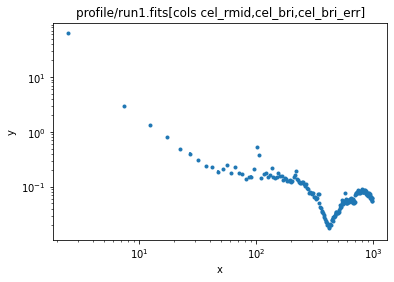

In [28]:
ui.plot_data(xlog=True, ylog=True)

We could try fitting this, but the feature at 400 arcseconds is not easy to model! What is causing this?

In [29]:
!echo 'circle(116.07272d, 37.88809722d, 400")' > profile/circle.reg

In [30]:
!ds9 9774/fluxed/broad_thresh.img -pan to 116.07272 37.88809722 ICRS \
  -zoom 4 -scale log -regions profile/circle.reg

We can see that this dip at ~ 400 arcseconds is related to the gap between the ACIS-S and ACIS-I arrays!

![image](images/ds9_05.png)

Can we account for this in our modelling or fitting?

There are several ways

 - use the exposure map to define those pixels with signal
 - filter the event file with the FOV file or the exposure map to store the filter in the subspace of the file: https://cxc.cfa.harvard.edu/ciao/ahelp/subspace.html
 
Using the `exp` argument to send in an exposure map to `dmextract` lets us try the first approach
(note that we use the new `CEL_FLUX` and `CEL_FLUX_ERR` columns):

In [31]:
!punlearn dmextract
!dmextract "9774/fluxed/broad_thresh.img[bin sky=annulus(116.0728015671739d,37.8881248629715d,0:2000:10)]" \
    exp=9774/fluxed/broad_thresh.expmap out=profile/run2.fits opt=generic clob+

In [32]:
!dmlist "profile/run2.fits[cols cel_flux,cel_flux_err]" cols

 
--------------------------------------------------------------------------------
Columns for Table Block HISTOGRAM
--------------------------------------------------------------------------------
 
ColNo  Name                 Unit        Type             Range
   1   CEL_FLUX             photons/cm**2/arcsec**2/s Real8          -Inf:+Inf            
   2   CEL_FLUX_ERR         photons/cm**2/arcsec**2/s Real8          -Inf:+Inf            


In [33]:
ui.load_data('profile/run2.fits[cols cel_rmid,cel_flux,cel_flux_err]')

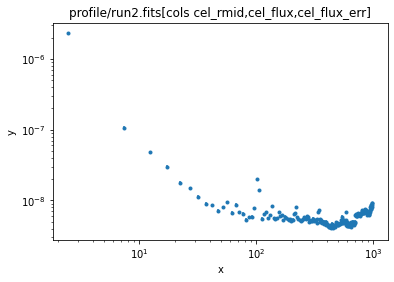

In [34]:
ui.plot_data(xlog=True, ylog=True)

Note that the background is now "more flat" (but not perfectly flat).

Since we are using the flux values the per-bin values are small, so I am going to take a $10^{-9}$ factor outside the models (which helps the fits).
First let's get a handle on the background, which I am going to model as a constant:

In [35]:
ui.set_source(1e-9 * ui.const1d.bgnd)

In [36]:
ui.fit()

Dataset               = 1
Method                = levmar
Statistic             = chi2
Initial fit statistic = 96099.5
Final fit statistic   = 11941.2 at function evaluation 4
Data points           = 200
Degrees of freedom    = 199
Probability [Q-value] = 0
Reduced statistic     = 60.0062
Change in statistic   = 84158.3
   bgnd.c0        5.70904      +/- 0.0162324   


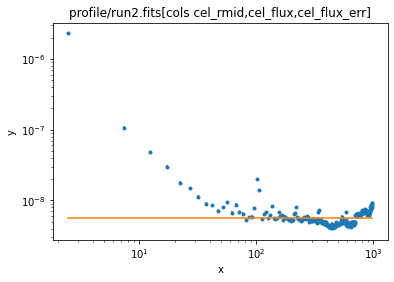

In [37]:
ui.plot_fit(xlog=True, ylog=True)

We can now add in a beta1d profile - https://cxc.cfa.harvard.edu/sherpa/ahelp/beta1d.html - which is commonly used to model the X-ray emission of galaxy clusters:

In [38]:
ui.set_source(1e-9 * (bgnd + ui.beta1d.clus))

# help the fit out a bit
clus.r0 = 10
clus.ampl = 100

In [39]:
ui.fit()

Dataset               = 1
Method                = levmar
Statistic             = chi2
Initial fit statistic = 10978.3
Final fit statistic   = 5360.07 at function evaluation 1024
Data points           = 200
Degrees of freedom    = 196
Probability [Q-value] = 0
Reduced statistic     = 27.3473
Change in statistic   = 5618.2
   bgnd.c0        5.65468      +/- 0.0164242   
   clus.r0        0.0354291    +/- 0.00114008  
   clus.beta      0.573769     +/- 0.00273697  
   clus.ampl      6.95986e+07  +/- 0           


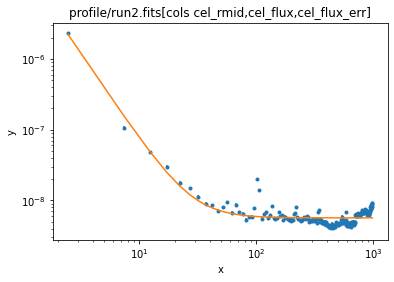

In [40]:
ui.plot_fit(xlog=True, ylog=True)

The fit "looks okay", but if you look you can see that the "core radius" (the `r0` parameter of the `beta1d` model) is - to this cluster person - rather small (the axis is in arcseconds so 0.04 arcseconds is a **lot** smaller than the Chandra PSF). There can be many reasons for this, including the fact that the model may just not be appropriate. I know (from work we've done on this system, and from the image we've seen) that there's a bright QSO at the center of the cluster, and this is likely causing problems, so let's ignore the first bin:

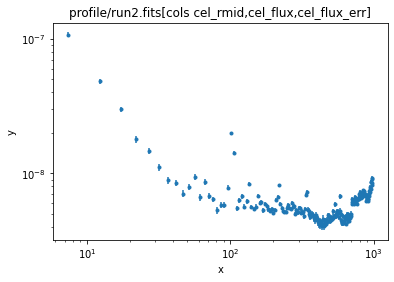

In [41]:
ui.ignore(0, 5)
ui.plot_data(xlog=True, ylog=True)

In [42]:
clus.r0 = 10
clus.ampl = 100

ui.fit()

Dataset               = 1
Method                = levmar
Statistic             = chi2
Initial fit statistic = 5280.15
Final fit statistic   = 5109.11 at function evaluation 58
Data points           = 199
Degrees of freedom    = 195
Probability [Q-value] = 0
Reduced statistic     = 26.2005
Change in statistic   = 171.048
   bgnd.c0        5.59349      +/- 0.0190334   
   clus.r0        3.83566      +/- 1.06328     
   clus.beta      0.508771     +/- 0.0117872   
   clus.ampl      500.723      +/- 212.093     


This looks more realistic and still seems to fit the data:

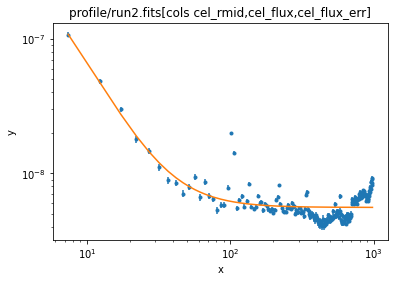

In [43]:
ui.plot_fit(xlog=True, ylog=True)

If we add back in the first bin we can see the excess emission that appears to be in the first bin:

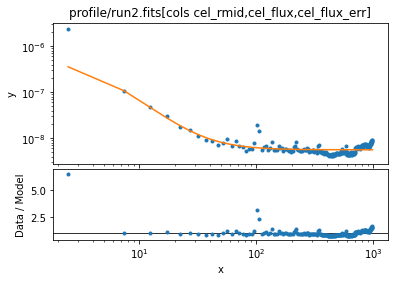

In [44]:
ui.notice(None, 5)

ui.plot_fit_ratio(xlog=True, ylog=True)

## Things that could be done better

- I have not removed point sources from the data, which contributes to the background and some of the spikes.

- I am using the default `fluximage` output, which was binned at 8 ACIS pixels. Since we want to either model, or exclude, the central QSO, we should use a smaller binning factor (if you want to model the PSF then probably so-called "sub-pixel" resolution).

- The cluster emission is not spherical, so we should use a better model, which could be

  - use elliptical rather than circluar annuli
  
  - fit a two-dimensional model to the date rather than fitting to the profile (e.g. https://cxc.cfa.harvard.edu/sherpa/ahelp/beta2d.html)
  
- Optimize the energy range for the analysis. The data here used the 0.5 - 7.0 keV band range (the so-called `"broad"` band), but you **may** get better results with a lower upper-limit (this depends on the source and background spectra).

- Use more data.

---

## Better resolution?

Let's **quickly** look at using smaller pixels (in this case the default 0.492 arcsecond
pixel size, and only looking at the "central" chip):

In [45]:
!ls 9774/repro

acisf09774_000N002_bpix1.fits  acisf09774_repro_evt2.fits
acisf09774_000N002_fov1.fits   acisf09774_repro_flt2.fits
acisf09774_000N002_msk1.fits   acisf09774_repro_fov1.fits
acisf09774_000N002_mtl1.fits   acisf313306795N002_pbk0.fits
acisf09774_000N002_stat1.fits  pcadf09774_repro_asol1.fits
acisf09774_asol1.lis	       pcadf313307273N002_asol1.fits
acisf09774_repro_bpix1.fits


Let's find what chip the cluster is on (spoiler, it's ACIS-S3, also ACIS-7):

In [46]:
!ds9 9774/repro/acisf09774_repro_evt2.fits -scale log

![image](images/ds9_bin1_invert.png)

In [47]:
!fluximage "9774/repro/acisf09774_repro_evt2.fits[ccd_id=7]" 9774/ccd7/ bin=1

Running fluximage
Version: 01 April 2020

Using CSC ACIS broad science energy band.
Aspect solution 9774/repro/pcadf09774_repro_asol1.fits found.
Bad-pixel file 9774/repro/acisf09774_repro_bpix1.fits found.
Mask file 9774/repro/acisf09774_000N002_msk1.fits found.

The output images will have 1257 by 1261 pixels, pixel size of 0.492 arcsec,
    and cover x=3422.5:4679.5:1,y=3177.5:4438.5:1.

Running tasks in parallel with 12 processors.
Creating aspect histogram for obsid 9774
Creating instrument map for obsid 9774
Creating exposure map for obsid 9774
Thresholding data for obsid 9774
Exposure-correcting image for obsid 9774

The following files were created:

 The clipped counts image is:
     9774/ccd7/broad_thresh.img

 The clipped exposure map is:
     9774/ccd7/broad_thresh.expmap

 The exposure-corrected image is:
     9774/ccd7/broad_flux.img



For this example I am not going to include an exposure image:

**NOTE**: the radial bins are narrower, and only extend to r=200 pixel (~100 arcseconds).

In [48]:
!punlearn dmextract
!dmextract "9774/ccd7/broad_thresh.img[bin sky=annulus(116.0728015671739d,37.8881248629715d,0:200:2)]" \
    out=profile/run3.fits opt=generic clob+

In [49]:
ui.load_data('profile/run3.fits[cols cel_rmid,cel_bri,cel_bri_err]')

In [50]:
ui.set_source(ui.const1d.bgnd2 + ui.beta1d.clus2)

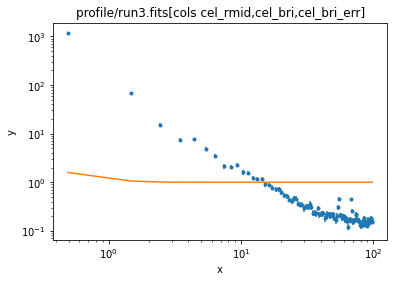

In [51]:
ui.plot_fit(xlog=True, ylog=True)

In [52]:
ui.ignore(0, 3)

In [53]:
ui.fit()

Dataset               = 1
Method                = levmar
Statistic             = chi2
Initial fit statistic = 109542
Final fit statistic   = 261.261 at function evaluation 114
Data points           = 97
Degrees of freedom    = 93
Probability [Q-value] = 6.65587e-18
Reduced statistic     = 2.80926
Change in statistic   = 109281
   bgnd2.c0       0.130091     +/- 0.00562411  
   clus2.r0       3.22239      +/- 0.56635     
   clus2.beta     0.495608     +/- 0.0143645   
   clus2.ampl     16.8629      +/- 3.57039     


As a reminder, our previous fit reported

    bgnd.c0        5.60187      +/- 0.0189266   
    clus.r0        3.90492      +/- 1.02941     
    clus.beta      0.5119       +/- 0.0119744   
    clus.ampl      492.813      +/- 195.968     

(and the units of the amplitude are different now).

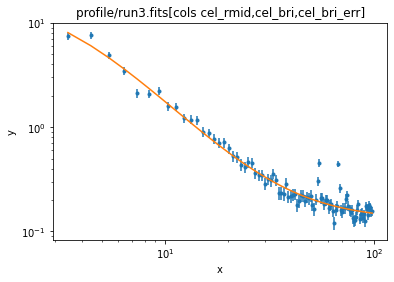

In [54]:
ui.plot_fit(xlog=True, ylog=True)

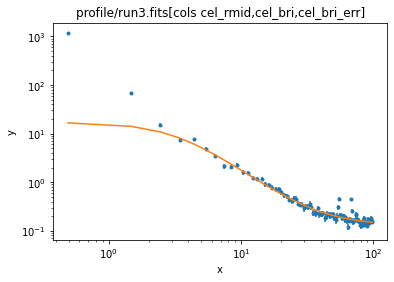

In [55]:
ui.notice()

ui.plot_fit(xlog=True, ylog=True)

If I had time I would talk about including a "point source" model to account for the QSO in the cluster, and fitting a two-dimensional model. There are a number of Sherpa threads that you can read up on!

---

## How can I use more data?

Be **VERY** careful using `dmmerge`

https://cxc.cfa.harvard.edu/ciao/ahelp/dmmerge.html

Consider this example of two overlapping (but with separate aim points) ObsIds (we are looking at the outlines of the FOV files):

![image](images/fovs.png)

If we just `dmmerge` the `evt2` files we get the following, because the two observations have a different mapping between
SKY coordinates (values ~ 1 - 8192) and celestial coordinates:

![image](images/merge_bad.png)

We have to **reproject** the data so that the SKY coordinates make sense:

![image](images/merge_good.png)

Note that even with reprojection the different datasets are not guaranteed to merge nicely together:

- exposure times are normally different

- unless the observations have a similar aim point then the PSF size at a given celestial location will differ for the different datasets

- background levels can vary when Front-Illuminated and Back-Illuminated chips overlap

# Pop Quiz

- Which detector has BI chips?

---

We used to have a script called `merge_all` that a user had written that attempted to combine ObsIds, but
it still had issues, and we now **strongly recomment** that you use `merge_obs` or the combination of `reproject_obs` and `flux_obs`:

https://cxc.cfa.harvard.edu/ciao/ahelp/merge_obs.html

https://cxc.cfa.harvard.edu/ciao/ahelp/reproject_obs.html

https://cxc.cfa.harvard.edu/ciao/ahelp/flux_obs.html


So this should be taken to be a note about all the things that **can** go wrong when merging data!

![image](images/merge_comparison.png)

The `merge_obs` command will

 - reproject all the ObsIds to an "average" tangent point
 
 - create images and exposure maps for each ObsId and each band
 
 - combine the images
 
 - create a merged event file which **SHOULD NOT BE USED TO EXTRACT SPECTRA**
 
If you have multiple CPU cores then it can run relatively fast (especially with its default bin size), but be warned!

# Pop Quiz

- Why did I list the `FP` value for each observation (this gives the temperature of the focal-plane instrument for the observation)

- Does anyone rember Kenny's discussion about SIM_Z values yesterday?

- What on earth does `Obsid 3098 has EXPTIME=0.4 and the rest have 3.1` mean?

---

In [56]:
!punlearn merge_obs
!merge_obs "*/repro/" merged/ bands=csc,broad

Running merge_obs
Version: 05 November 2020

Found 3098/repro/acisf03098_repro_evt2.fits
Found 9407/repro/acisf09407_repro_evt2.fits
Found 9408/repro/acisf09408_repro_evt2.fits
Found 9774/repro/acisf09774_repro_evt2.fits
Found 9775/repro/acisf09775_repro_evt2.fits
Verifying 5 observations.
Using CSC ACIS soft science energy band.
Using CSC ACIS medium science energy band.
Using CSC ACIS hard science energy band.
Using CSC ACIS broad science energy band.
Calculating new tangent point.
New tangent point: RA=7h 44m 17.681s Dec=37d 54' 1.26"

Observations to be reprojected:

  Obsid  Obs Date   Exp    DETNAM     SIM_Z    FP   Sepn   PA  
                   (ks)                (mm)    (K)   (')  (deg)
---------------------------------------------------------------
1 3098  2002-05-16  34.4 ACIS-7      -190.143 153.3   1.3  -168
2 9407  2007-12-03  66.3 ACIS-23567  -190.140 154.1   0.3   +15
3 9774  2007-12-06  75.1 ACIS-23567  -190.140 154.4   0.3   +12
4 9775  2007-12-08  15.9 ACIS-23567  -

In [57]:
!ds9 merged/broad_flux.img -scale log -zoom 2 -cmap viridis

This is ~200 ks of data, compared to the 75 ks we have looked at earlier:

![image](images/ds9_06.png)

We can also look for spectral differences (Galaxy clusters tend not to show significant broad-band color variations, but the point sources can be more colorful):

In [58]:
!ds9 -scale log -zoom 2 -rgb \
  -red merged/soft_flux.img \
  -green merged/medium_flux.img \
  -blue merged/hard_flux.img

![image](images/ds9_07.png)

---

This only scratches the surface. I could

- discuss PSF images (e.g. what "is" the PSF size for a point on the sky whem you have overlapping ObsIds)

- how do I run source detection on multiple datasets (can we combine, or fit separately)

- how do I create spectra for multiple observations?

It is **VITALLY IMPORTANT** to know when you can use "combined" or "merged" data (such as the images created by `merge_obs`) and when do we multiple datasets (such as spectral fitting). It depends on how important knowledge of the instrument response for each point on the sky is:

- these values can depend on position on the detector (e.g. PSF size or the effective area)

- do these values vary with time (e.g. due to the build-up of contamination on the ACIS filter or the detector response as the focal-plane temperature has changed). 